# PINN for flow around a cylinder
The Navier-Stokes equations are being solved for incompressible flow around a cylinder. These equations are a set of partial differential equations (PDEs) governing the motion of fluid substances. For a 2D incompressible, viscous flow, they can be written in the Cartesian coordinate system as follows:

## Continuity Equation:

The continuity equation represents the conservation of mass, stating that the mass entering a control volume must equal the mass exiting the volume, plus any change in mass within the volume. For an incompressible flow, it simplifies to:

$$ \nabla u = 0 $$

or, in a two-dimensional form:

$$
\begin{equation}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\tag{1}
\end{equation}
$$

where u and v are the velocity components in the x and y directions respectively.

## Momentum Equations:

The momentum equations represent the conservation of momentum. They are the result of applying Newton's second law (force equals the rate of change of momentum) to fluid motion. The Navier-Stokes equations include the effects of viscosity, which are modeled with a Laplacian operator. The momentum equations for an incompressible flow can be written as:

$$
\begin{equation}
\rho \left( \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} \right) = -\frac{\partial p}{\partial x} + \nu \nabla^2 u
\tag{2}
\end{equation}
$$
$$
\begin{equation}
\rho \left( \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} \right) = -\frac{\partial p}{\partial y} + \nu \nabla^2 v
\tag{3}
\end{equation}
$$

where:

ρ is the fluid density
u, v are the velocity components in the x and y directions, respectively
t is time
p is pressure
ν is the kinematic viscosity
∇² is the Laplacian operator, denoting the divergence of the gradient of a scalar field, here used to represent the diffusion of momentum (due to viscosity)
The pressure-Poisson equation is also used to enforce incompressibility:

$$
\begin{equation}
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = b
\tag{4}
\end{equation}
$$
where
$$
\begin{equation}
b = \rho \left( \frac{1}{\Delta t} (\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}) - (\frac{\partial u}{\partial x})^2 - 2 \frac{\partial u}{\partial y} \frac{\partial v}{\partial x} - (\frac{\partial v}{\partial y})^2 \right)
\tag{5}
\end{equation}
$$


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import math
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

In [2]:
xmax = 1.0
ymax = 1.0
tmax = 0.1

Nx = 64
Ny = 64
Nt = 1000

dx = xmax / (Nx - 1)
dy = ymax / (Ny - 1)
dt = tmax / (Nt - 1)

Nit=50 
c = 1

x = np.linspace(0, xmax, Nx)
y = np.linspace(0, ymax, Ny)
X, Y = np.meshgrid(x, y)

In [3]:
rho = 1
mu = .1

In [4]:
# Define the cylinder
center = [0.5, 0.5]  # center of the cylinder
radius = 0.1  # radius of the cylinder

In [5]:
def compute_grad(x, y):
        return torch.autograd.grad(x, y, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True, only_inputs=True)[0]

In [6]:
class PINN(nn.Module):
    def __init__(self, hidden_units):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        in_units = 3
        out_units = 3
        for units in hidden_units:
            layer = nn.Linear(in_units, units)
            nn.init.xavier_normal_(layer.weight)
            self.layers.append(layer)
            in_units = units
        output_layer = nn.Linear(in_units, out_units)
        nn.init.xavier_normal_(output_layer.weight)
        self.layers.append(output_layer)

    def forward(self, x, y, t):
        
        input = torch.cartesian_prod(x.flatten(), y.flatten(), t.flatten())
        
        for layer in self.layers[:-1]:
            output = torch.tanh(layer(input))
            input = output
        output = self.layers[-1](input)
        u = output[:, 0]
        v = output[:, 1]
        p = output[:, 2]
        
        return u, v, p

    def mse_f(self, x, y, t):

        u, v, p = self(x, y, t)

        # Compute derivatives of u
        u_t = compute_grad(u, t)
        u_x = compute_grad(u, x)
        u_y = compute_grad(u, y)
        u_xx = compute_grad(u_x, x)
        u_yy = compute_grad(u_y, y)

        # Compute derivatives of v
        v_t = compute_grad(v, t)
        v_x = compute_grad(v, x)
        v_y = compute_grad(v, y)
        v_xx = compute_grad(v_x, x)
        v_yy = compute_grad(v_y, y)

        # Compute derivatives of p
        p_x = compute_grad(p, x)
        p_xx = compute_grad(p_x, x)
        p_y = compute_grad(p, y)
        p_yy = compute_grad(p_y, y)

        b = rho * (1/dt * (u_x + v_y) - u_x**2 - 2*u_y*v_x - v_y**2)

        f1 = u_t + u*u_x + v*u_y + (1/rho) * p_x - mu * (u_xx + u_yy)
        f2 = v_t + u*v_x + v*v_y + (1/rho) * p_y - mu * (v_xx + v_yy)
        f3 = u_x + v_y
        f4 = p_xx + p_yy - b
        
        _mse = (1 / Nf) * torch.mean(torch.square(f1)) + \
                           torch.mean(torch.square(f2)) + \
                           torch.mean(torch.square(f3)) + \
                           torch.mean(torch.square(f4))

        return _mse
    
    def mse_ic(self):
        return
    
    def mse_left_bc(self, y, t):

        x = torch.zeros_like(y)
        u, v, p = self(x, y, t)

        _mse = torch.mean( torch.square(u - torch.ones_like(u)) + torch.square(v - torch.zeros_like(v)) )

        return _mse
    
    def mse_right_bc(self, y, t):

        x = torch.ones_like(y)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)
        v_t = compute_grad(v, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v_t) )

        return _mse
    
    def mse_up_bc(self, x, t):

        y = torch.ones_like(x)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v) )

        return _mse
    
    def mse_down_bc(self, x, t):

        y = torch.zeros_like(x)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v) )

        return _mse
    
    def mse_cylinder_bc(self):
        return

    def loss(self):
        return

In [7]:
def get_collocation_points(xmin, xmax, ymin, ymax, center, radius, n):
    
    x = []
    y = []
    
    h, k = center  # center of the circle

    while len(x) < n:  # generate Nf points
        # Generate random point in the rectangle
        x_point = xmin + (xmax - xmin) * random.random()
        y_point = ymin + (ymax - ymin) * random.random()
        
        # Check if point is outside the circle
        if (x_point - h) ** 2 + (y_point - k) ** 2 >= radius ** 2:
            x.append(x_point)
            y.append(y_point)

    return x, y

def get_boundary_points(xmin, xmax, n):
    return [xmin + (xmax - xmin) * random.random() for _ in range(n)]

def get_cylinder_bc_points(center, radius, n):
    x_center, y_center = center
    x = []
    y = []

    for _ in range(n):
        # Generate random angle and random radius
        rand_angle = 2 * math.pi * random.random()
        rand_radius = radius * math.sqrt(random.random())
        # Convert polar coordinates to cartesian
        x_point = x_center + rand_radius * math.cos(rand_angle)
        y_point = y_center + rand_radius * math.sin(rand_angle)
        # Append to the lists
        x.append(x_point)
        y.append(y_point)

    return x, y

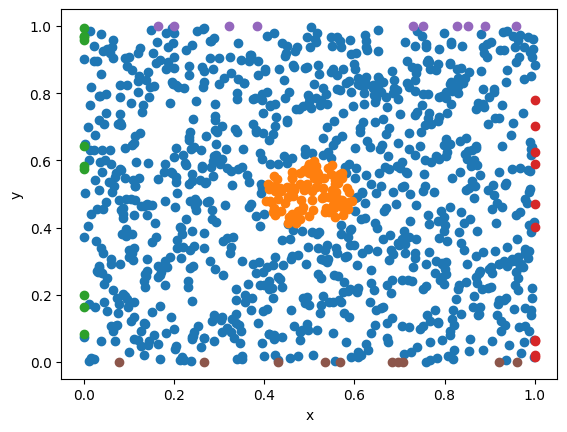

In [9]:

Nf = 1000
Nb_cylinder = 100
Nb = 100

xf, yf = get_collocation_points(0, xmax, 0, ymax, center, radius, Nf)

xb_cylinder, yb_cylinder = get_cylinder_bc_points(center, radius, Nb_cylinder)

xb_left = np.zeros(Nb)
yb_left = get_boundary_points(0, ymax, Nb)

xb_right = np.ones(Nb)
yb_right = get_boundary_points(0, ymax, Nb)

xb_up = get_boundary_points(0, xmax, Nb)
yb_up = np.ones(Nb)

xb_down = get_boundary_points(0, xmax, Nb)
yb_down = np.zeros(Nb)

plt.figure()
plt.scatter(xf, yf)
plt.scatter(xb_cylinder, yb_cylinder)
plt.scatter(xb_left, yb_left)
plt.scatter(xb_right, yb_right)
plt.scatter(xb_up, yb_up)
plt.scatter(xb_down, yb_down)
plt.xlabel("x")
plt.ylabel("y")
plt.show()